In [6]:
import math

import ccxt
from crypto_data_fetcher.gmo import GmoFetcher
import joblib
# import lightgbm as lgb
import matplotlib.pyplot as plt
# import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
import gokart
import luigi

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [11]:
class LoadOHLCV(gokart.TaskOnKart):
    market = luigi.Parameter()
    interval_sec = luigi.IntParameter()
    mem_cache_path = luigi.Parameter(default='/tmp/gmo_fetcher_cache')

    def run(self):
        memory = joblib.Memory(self.mem_cache_path, verbose=0)
        fetcher = GmoFetcher(memory=memory)

        # GMOコインのBTC/JPYレバレッジ取引 ( https://api.coin.z.com/data/trades/BTC_JPY/ )を取得
        # 初回ダウンロードは時間がかかる
        df = fetcher.fetch_ohlcv(
            market=self.market, # 市場のシンボルを指定
            interval_sec=self.interval_sec, # 足の間隔を秒単位で指定。この場合は15分足
        )

        # 実験に使うデータ期間を限定する
        df = df[df.index < pd.to_datetime('2021-04-01 00:00:00Z')]
        self.dump(df)

df = gokart.build(LoadOHLCV(interval_sec=15 * 60, market='BTC_JPY'))
display(df)

,op,hi,lo,cl,volume
timestamp,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77
...,...,...,...,...,...
2021-03-31 22:45:00+00:00,6500673.0,6515799.0,6495153.0,6501148.0,24.83
2021-03-31 23:00:00+00:00,6500548.0,6514344.0,6491034.0,6504636.0,48.64
2021-03-31 23:15:00+00:00,6505950.0,6529377.0,6491838.0,6523540.0,38.07


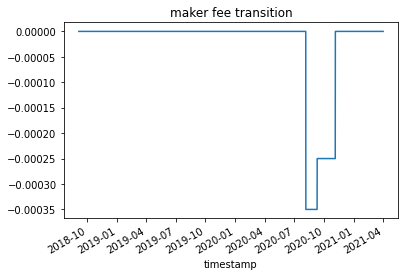

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01,0.0
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01,0.0
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03,0.0
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22,0.0
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77,0.0
...,...,...,...,...,...,...
2021-03-31 22:45:00+00:00,6500673.0,6515799.0,6495153.0,6501148.0,24.83,0.0
2021-03-31 23:00:00+00:00,6500548.0,6514344.0,6491034.0,6504636.0,48.64,0.0
2021-03-31 23:15:00+00:00,6505950.0,6529377.0,6491838.0,6523540.0,38.07,0.0


In [12]:
class MergeFee(gokart.TaskOnKart):
    ohlcv = gokart.TaskInstanceParameter()

    def run(self):
        df = self.load_data_frame('ohlcv')
        maker_fee_history = [
            {
                # https://coin.z.com/jp/news/2020/08/6482/
                # 変更時刻が記載されていないが、定期メンテナンス後と仮定
                'changed_at': '2020/08/05 06:00:00Z',
                'maker_fee': -0.00035
            },
            {
                # https://coin.z.com/jp/news/2020/08/6541/
                'changed_at': '2020/09/09 06:00:00Z',
                'maker_fee': -0.00025
            },
            {
                # https://coin.z.com/jp/news/2020/10/6686/
                'changed_at': '2020/11/04 06:00:00Z',
                'maker_fee': 0.0
            },
        ]

        # 初期の手数料
        # https://web.archive.org/web/20180930223704/https://coin.z.com/jp/corp/guide/fees/
        df['fee'] = 0.0

        for config in maker_fee_history:
            df.loc[pd.to_datetime(config['changed_at']) <= df.index, 'fee'] = config['maker_fee']

        self.dump(df)

df = gokart.build(MergeFee(ohlcv=LoadOHLCV(interval_sec=15 * 60, market='BTC_JPY')))

df['fee'].plot()
plt.title('maker fee transition')
plt.show()
display(df)

In [13]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

In [14]:
df = df.dropna()
df = calc_features(df)
display(df)

,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77,0.0,983.257246,-682.2,-2347.657246,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,832.728623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 22:45:00+00:00,6500673.0,6515799.0,6495153.0,6501148.0,24.83,0.0,23181.091959,3403.6,-16373.891959,24338.412269,...,0.725659,0.999646,1,0.220332,0.791673,7450.342857,-89.950005,22348.657143,-1146.024176,9888.745979
2021-03-31 23:00:00+00:00,6500548.0,6514344.0,6491034.0,6504636.0,48.64,0.0,7228.746675,1552.0,-4124.746675,24591.910992,...,0.746594,0.998346,1,0.729872,0.795980,5234.600000,-89.885707,11751.542857,-501.303297,2838.373338
2021-03-31 23:15:00+00:00,6505950.0,6529377.0,6491838.0,6523540.0,38.07,0.0,13610.327207,-3138.5,-19887.327207,16722.553326,...,0.690296,0.999724,1,0.314238,0.802666,-13763.742857,-89.932067,-2799.400000,-843.410989,8374.413604


In [ ]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])